In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
#from torchvision.transforms import Compose, ToPILImage, ToTensor, Resize
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision
import numpy as np
import h5py
from matplotlib import pyplot as plt
plt.ion()   # interactive mode

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# downloading ABIDE 1 dataset, 4mmm resolution
!wget https://www.dropbox.com/s/fo12doky65vhvet/X_4mm.h5?dl=1 -O X_4mm.h5

--2018-02-07 11:00:08--  https://www.dropbox.com/s/fo12doky65vhvet/X_4mm.h5?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/x9tUKnmsdwpsjYE3j6Hz5VujjM0ArA9rp1XYTt4XE6T98G7DyyoyCRCpDX5wNpWo/file?dl=1 [following]
--2018-02-07 11:00:08--  https://dl.dropboxusercontent.com/content_link/x9tUKnmsdwpsjYE3j6Hz5VujjM0ArA9rp1XYTt4XE6T98G7DyyoyCRCpDX5wNpWo/file?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.1.6, 2620:100:6016:6::a27d:106
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.1.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 913623776 (871M) [application/binary]
Saving to: ‘X_4mm.h5’

X_4mm.h5            100%[===================>] 871.30M  58.0MB/s    in 16s     

2018-02-07 

In [4]:
def load_large_dataset(file_name):
    h5f = h5py.File(file_name + '.h5','r')
    variable = h5f['variable'][:]
    h5f.close()
    return variable

In [5]:
X = load_large_dataset('X_4mm')

In [6]:
LATENT_DIM = 5 #size of the latent space in the variational autoencoder
BATCH_SIZE = 128
NUMBER_OF_IMAGES = len(X)

In [7]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        
        # layers for encoder
        self.conv1 = nn.Conv3d(1, 8, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv3d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(32*5*6*5, LATENT_DIM)
        self.fc2 = nn.Linear(32*5*6*5, LATENT_DIM)
        
        #self.conv2_bn = nn.BatchNorm2d(32)
        
        # layers for decoder
        self.fc_decoder = nn.Linear(LATENT_DIM, 32*5*6*5)
        
        self.conv1_decoder = nn.Conv3d(32, 32, kernel_size=3, padding=1) 
        self.conv2_decoder = nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.conv3_decoder = nn.Conv3d(32, 32, kernel_size=3, padding=1)
        
        self.conv4_decoder = nn.Conv3d(32, 1, kernel_size=3, padding=3)
        
        
    def encode(self, x):
        x = F.relu(self.conv1(x)) #shape after conv: (8, 44, 53, 44)
        x = F.max_pool3d(x, kernel_size=2) #shape after pooling: (8, 22, 26, 22)

        x = F.relu(self.conv2(x)) #shape after conv: (16, 22, 26, 22)
        x = F.max_pool3d(x, kernel_size=2) #shape after pooling: (16, 11, 13, 11)
        
        x = F.relu(self.conv3(x)) #shape after conv: (32, 11, 13, 11)
        x = F.max_pool3d(x, kernel_size=2) #shape after pooling: (32, 5, 6, 5)

        x = x.view(-1, 5*6*5*32)
        return self.fc1(x), self.fc2(x)
    
    
    def reparameterize(self, mu, logvar):

        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    
    def decode(self, z):
        z = F.relu(self.fc_decoder(z))
        z = z.view(-1, 32,5,6,5) #reshape to (32, 5, 6, 5)
        
        z = F.relu(self.conv1_decoder(z)) #shape after conv (32, 5, 6, 5)
        z = F.upsample(z, scale_factor=2, mode='nearest') #shape after upsampling (32, 10, 12, 10)
        z = F.relu(self.conv2_decoder(z)) #shape after conv (32, 10, 12, 10)
        z = F.upsample(z, scale_factor=2, mode='nearest') #shape after upsampling (32, 20, 24, 20)
        z = F.relu(self.conv3_decoder(z)) #shape after conv (32,16,16)
        z = F.upsample(z, scale_factor=2, mode='nearest') #shape after conv (32, 40, 48, 40)
        z = self.conv4_decoder(z) #shape after conv (1, 44, 52, 44)
        z = F.pad(z, (0,0,0,1,0,0), "constant", -10) #after padding (1, 44, 53, 44) (to match the input size)
        return F.sigmoid(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar    

In [8]:
def loss_function(reconstruced_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstruced_x.view(-1, 44*53*44), x.view(-1, 44*53*44))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= BATCH_SIZE * (44*53*44) #batch_size=128

    return BCE + KLD

In [9]:
images = torch.from_numpy(X) #convert to torch tensor
images = images.view(NUMBER_OF_IMAGES, 1, 44, 53, 44) #reshape

In [10]:
train_set = torch.utils.data.TensorDataset(images, torch.zeros(NUMBER_OF_IMAGES))
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

In [11]:
net = VAE()
optimizer = optim.Adam(net.parameters())
net.cuda()

VAE(
  (conv1): Conv3d (1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d (8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d (16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc1): Linear(in_features=4800, out_features=5)
  (fc2): Linear(in_features=4800, out_features=5)
  (fc_decoder): Linear(in_features=5, out_features=4800)
  (conv1_decoder): Conv3d (32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2_decoder): Conv3d (32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3_decoder): Conv3d (32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4_decoder): Conv3d (32, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 3, 3))
)

In [12]:
reconstructed_images = torch.zeros(15,1,44,53)
reconstructed_images_2 = torch.zeros(15,1,44,53)

In [ ]:
for epoch in range(151):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        reconstructed_batch, mu, logvar = net(inputs)
        
        outputs = net(inputs)
        loss = loss_function(reconstructed_batch, inputs, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]*inputs.size(0)

    print('Epoch %d, loss: %.3f' % (epoch + 1, running_loss / NUMBER_OF_IMAGES))
    
    if (epoch%10==0): #saving examples of reconstructed images every 10 epochs
      output = net(Variable(train_loader.dataset[0][0].unsqueeze(0).cuda()))
      output = output[0].data.view(1,44,53,44).cpu()
      reconstructed_images[int(epoch/10)] = output[0,:,:,28] #slice number 28
      reconstructed_images_2[int(epoch/10)] = output[0,:,:,10] #slice number 10
    
    
print('Finished Training')

Epoch 1, loss: 0.618
Epoch 2, loss: 0.424
Epoch 3, loss: 0.314
Epoch 4, loss: 0.296
Epoch 5, loss: 0.287
Epoch 6, loss: 0.280
Epoch 7, loss: 0.277
Epoch 8, loss: 0.274
Epoch 9, loss: 0.272
Epoch 10, loss: 0.271
Epoch 11, loss: 0.269
Epoch 12, loss: 0.267
Epoch 13, loss: 0.263
Epoch 14, loss: 0.261
Epoch 15, loss: 0.261
Epoch 16, loss: 0.260
Epoch 17, loss: 0.258
Epoch 18, loss: 0.257
Epoch 19, loss: 0.256
Epoch 20, loss: 0.256
Epoch 21, loss: 0.255
Epoch 22, loss: 0.254
Epoch 23, loss: 0.253
Epoch 24, loss: 0.252
Epoch 25, loss: 0.251
Epoch 26, loss: 0.251
Epoch 27, loss: 0.250
Epoch 28, loss: 0.249
Epoch 29, loss: 0.248
Epoch 30, loss: 0.247
Epoch 31, loss: 0.247
Epoch 32, loss: 0.246
Epoch 33, loss: 0.245
Epoch 34, loss: 0.245
Epoch 35, loss: 0.244
Epoch 36, loss: 0.243
Epoch 37, loss: 0.242
Epoch 38, loss: 0.242
Epoch 39, loss: 0.241
Epoch 41, loss: 0.240
Epoch 42, loss: 0.239
Epoch 43, loss: 0.238
Epoch 44, loss: 0.237
Epoch 45, loss: 0.237
Epoch 46, loss: 0.236
Epoch 47, loss: 0.2

IndexError: index 15 is out of range for dimension 0 (of size 15)

Let's see how the quality of reconstructed images improve over training time. The original image looks like this:

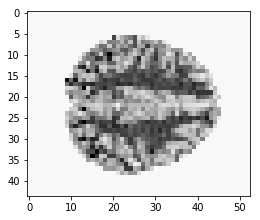

In [22]:
fig = plt.figure(figsize=(4,4))
my_slice = images[0,0,:,:,28]
plt.imshow(my_slice, cmap="Greys")

and below we show reconstructions of the above slice every 10 epochs

In [16]:
grid_1 = torchvision.utils.make_grid(reconstructed_images, nrow=5)
grid_2 = torchvision.utils.make_grid(reconstructed_images_2, nrow=5)
grid_1 = grid_1[0,:,:]
grid_2 = grid_2[0,:,:]

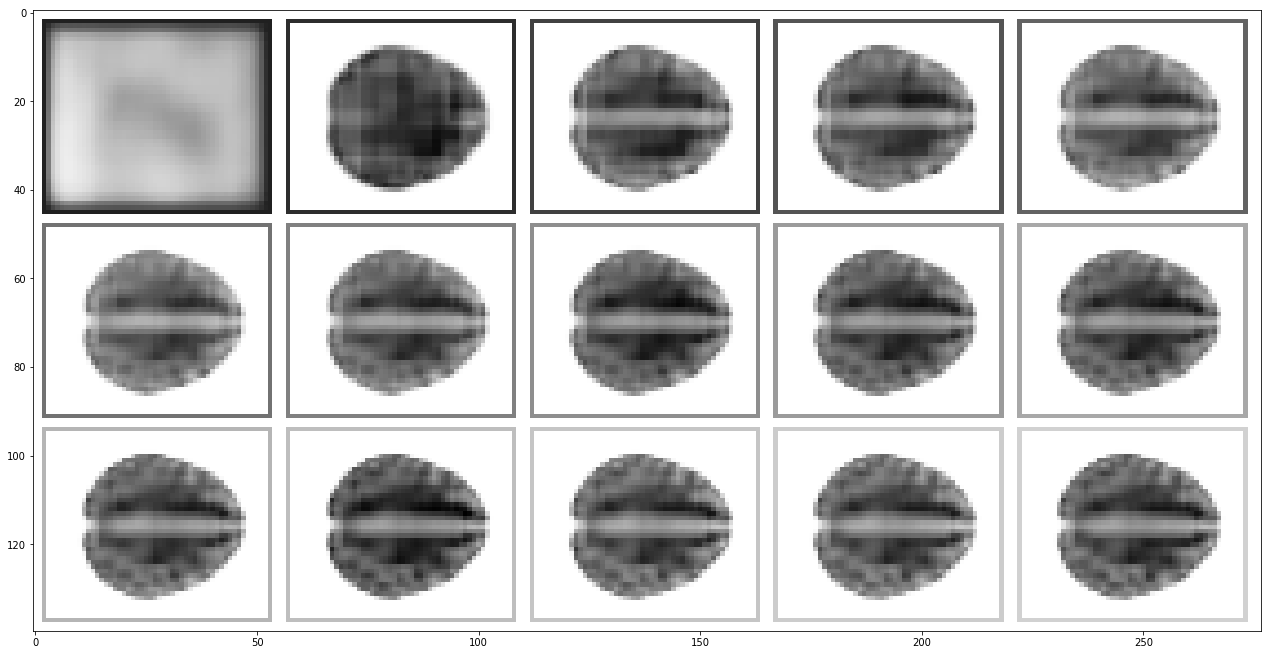

In [17]:
plt.rcParams['grid.linewidth'] = 0.0
fig = plt.figure(figsize=(22,22))
plt.imshow(grid_1, cmap="Greys")

Let's check another slice

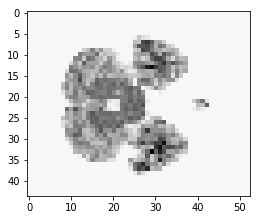

In [23]:
fig = plt.figure(figsize=(4,4))
my_slice = images[0,0,:,:,10]
plt.imshow(my_slice, cmap="Greys")

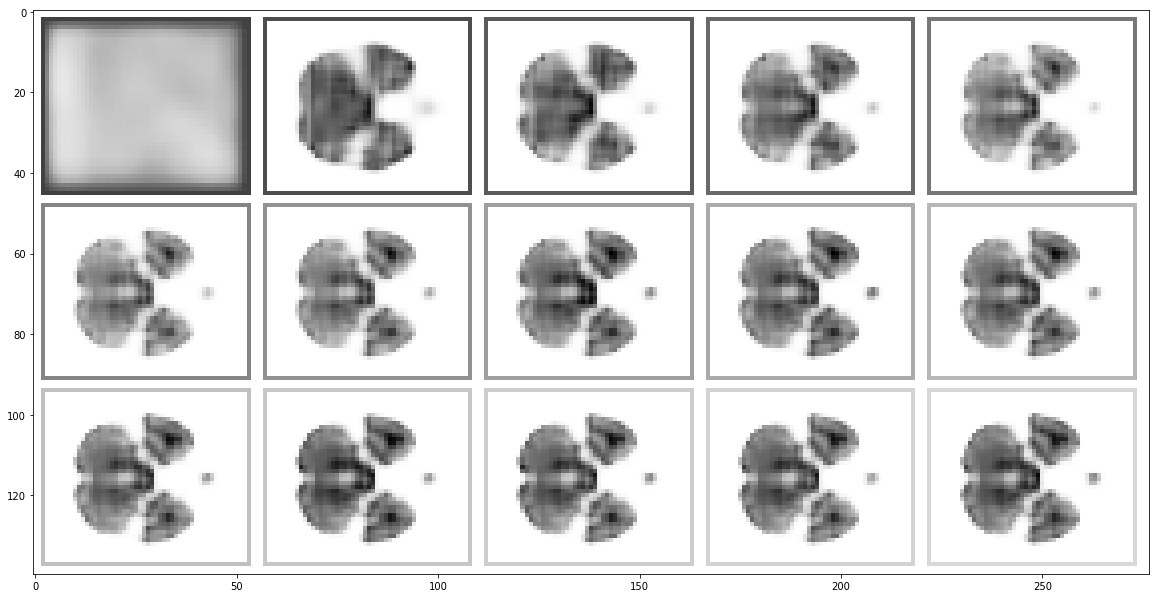

In [19]:
fig = plt.figure(figsize=(20,20))
plt.imshow(grid_2, cmap="Greys")

After 70-80 basically the reconstructed images look the same. However, the loss function still goes down (presumably latent space is getting closer to the desired distribution)